# CNN Formas Geométricas

In [1]:
import numpy as np
import pandas as pd
import os
import cv2

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from scipy.ndimage.filters import maximum_filter
import skimage.measure
from scipy.signal import convolve2d

# Preparação dos Dados

In [3]:
features = {}

In [4]:
for file in np.array(list(os.walk('../input/basicshapes/shapes')))[1:]:
    #print(file[0])
    directory = file[0]
    type = file[0].split('/')[-1]
    #print(type)
    if(type not in features.keys()):
        features[type] = []
    for img in file[2]:
        features[type].append(cv2.imread(directory + '/' + img, cv2.IMREAD_GRAYSCALE))

In [5]:
features.keys()

dict_keys(['circles', 'shapes', 'triangles', 'squares'])

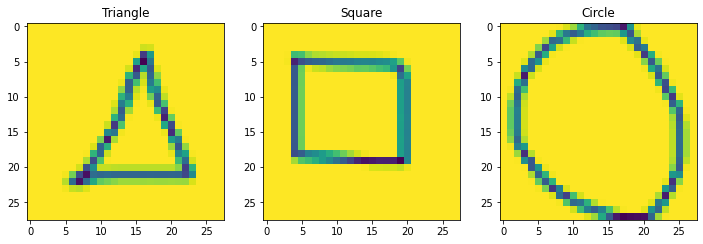

In [6]:
# Display a triangle
f, axarr = plt.subplots(1,3, figsize=(12, 12))
axarr[0].set_title('Triangle')
axarr[0].imshow(features['triangles'][1])
axarr[1].set_title('Square')
axarr[1].imshow(features['squares'][1])
axarr[2].set_title('Circle')
axarr[2].imshow(features['circles'][1])

In [7]:
X = np.array(features['triangles'] + features['squares'] + features['circles'])
y = np.array([[1, 0, 0]] * len(features['triangles']) + [[0, 1, 0]] * len(features['squares']) + [[0, 0, 1]] * len(features['circles']))
len(X)

600

In [8]:
# normalização
X = X / 255.0

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Funções de Ativação

In [10]:
def relu(x):
    mask = (x>0) * 1.0 
    return x * mask

def drelu(x):
    mask = (x>0) * 1.0 
    return  mask

In [11]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def dsigmoid(z):
    return sigmoid(z) * (1-sigmoid(z))

In [12]:
def softmax(s): 
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

# Forward Propagation

In [13]:
def forward(x, theta):
    k, w1, w2, w3, b1, b2, b3 = theta

    # conv2d
    m = np.array([convolve2d(x[i], k, mode='valid') for i in range(len(x))])
    n = relu(m)
    
    # maxpool
    o = np.array([skimage.measure.block_reduce(n[i], (2,2), np.max) for i in range(len(n))])

    # flatten
    f = o.reshape(o.shape[0], 121)

    # layers
    p = f.dot(w1) + b1
    q = sigmoid(p)

    r = q.dot(w2) + b2
    s = sigmoid(r)

    t = s.dot(w3) + b3
    u = softmax(t)

    return m, n, o, p, q, r, s, t, u

# BackPropagation

In [14]:
def backward(x, y, theta):
    k, w1, w2, w3, b1, b2, b3 = theta

    m, n, o, p, q, r, s, t, u = forward(x, theta)

    dloss = cross_entropy(u, y)

    dt = w3.dot(dloss.T).T
    ds = dt * dsigmoid(r)
    dr = w2.dot(ds.T).T
    dq = dr * dsigmoid(p)
    dp = w1.dot(dq.T).T

    db3 = dloss
    dw3 = dloss.T.dot(s).T

    db2 = ds
    dw2 = ds.T.dot(q).T

    db1 = dq
    dw1 = dq.T.dot(o.reshape(o.shape[0], 121)).T

    masks = np.array([np.equal(n[i], o[i].repeat(2, axis=0).repeat(2, axis=1)).astype(int) for i in range(len(n))])
    windows = np.array([masks[i] * dp[i].reshape(11,11).repeat(2, axis=0).repeat(2, axis=1) for i in range(len(masks))])

    dks = np.array([np.rot90(convolve2d(x[i],np.rot90(windows[i] * n[i],2 ),mode='valid'),2) for i in range(len(windows))])
    dk = np.mean(dks, axis=0)

    return dk, dw1, dw2, dw3, db1, db2, db3

In [15]:
np.random.seed(123213131)

k = np.random.uniform(size=(7,7))

w1 = np.random.uniform(size=(121, 64)) * np.sqrt(1./ 121.)
b1 = np.random.uniform(size=(1, 64)) * np.sqrt(1./ 64.)

w2 = np.random.uniform(size=(64, 32)) * np.sqrt(1./ 64.)
b2 = np.random.uniform(size=(1, 32)) * np.sqrt(1./ 32.)

w3 = np.random.uniform(size=(32, 3)) * np.sqrt(1./ 32.)
b3 = np.random.uniform(size=(1, 3)) * np.sqrt(1./ 3.)

theta = k, w1, w2, w3, b1, b2, b3

In [16]:
def optimize(grads, theta, lr=0.5):
    theta = tuple([theta[i] - (grads[i] * lr) for i in range(len(theta))])
    
    return theta

In [17]:
def error(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

In [ ]:
losses = []

In [ ]:
for e in range(5000):
    grads = backward(X_train, y_train, theta)
    theta = optimize(grads, theta)
    if(e % 500 == 0):
        l = error(forward(X_train, theta)[-1], y_train)
        losses.append(l)
        print("Epoch: {0}, Loss: {1}".format(e, l))

In [ ]:
plt.plot(losses)

# Precisão

In [ ]:
preds = np.argmax(forward(X_train, theta)[-1], axis=1)
real = np.argmax(y_train, axis=1)

In [ ]:
print("Accuracy: ", (preds == real).sum() / len(preds))